In [1]:
import numpy as np
import copy
import pandas as pd
import os
import sys
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

n_cores = multiprocessing.cpu_count()
sys.path.append("../node2vec2rank/")


sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
## experiment info that will be used for folder names and printing
tissue = 'HeLaS3'
network_inf_method = 'hdWGCNA'
gsea_exp_parent_folder_name = 'hdWGCNA_HeLaS3_paper'
save_gsea_results_notes = ''

In [3]:
# read the configuration file

from node2vec2rank.dataloader import DataLoader

import json

#read the config file
config = json.load(open('../configs/config_hdWGCNA.json', 'r'))

config = {param: value for section, params in config.items()
          for param, value in params.items()}

In [4]:
#load the data
dataloader = DataLoader(config)

There are 2949 row nodes and 2949 column nodes in graph 1
There are 2767 row nodes and 2767 column nodes in graph 2
There are 2621 row nodes and 2621 column nodes in graph 3
There are 2961 row nodes and 2961 column nodes in graph 4
There are 2420 common nodes and resulting networks will have size 2420 by 2420


In [5]:
#run n2v2r to get the borda and dedi rankings

from node2vec2rank.model import N2V2R

model = N2V2R(graphs=dataloader.graphs, config=config, nodes=dataloader.interest_nodes)
rankings = model.fit_transform_rank()

DeDi_rankings = model.degree_difference_ranking()
borda_ranking = model.aggregate_transform()



../output/01_02_2024_11_12_10

Running n2v2r with dimensions [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24] and distance metrics ['euclidean', 'cosine'] ...
	Multi-layer embedding in 4.84 seconds
n2v2r computed 66 rankings for 3 comparison(s) in 9.03 seconds

Rank aggregation with Borda ...
	Finished aggregation in 1.54 seconds


In [6]:
##get the rankings of the comparison 

#given that this is a sequential analysis with 4 graphs, for G1S we are interested in the first comparison, and the third for G2M
target = 'G1S'

comparison = '1'
n2v2r_borda_ranking_pd = borda_ranking[comparison].copy()
absDeDi_ranking_pd = DeDi_rankings[comparison][['absDeDi']].copy()

In [7]:
# run prerank GSEA
from node2vec2rank.post_utils import prerank_gseapy

save_results = True

# the gene set library
reac_pathway_fn = '../data/gene_set_libraries/human/c2.cp.reactome.v7.5.1.symbols.gmt'

# the parameters for prerank
prerank_weight = 0
prerank_min_path_size = 5
prerank_max_path_size = 1500
prerank_num_perms = 1500

n2v2r_borda_pre_REAC_pd = prerank_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
absDeDi_pre_REAC_pd = prerank_gseapy(absDeDi_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_borda_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r_borda" +
                            "_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                            "_absDeDi"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')

2023-12-25 11:13:01,959 [WARNING] Duplicated values found in preranked stats: 2.73% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-12-25 11:13:03,125 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


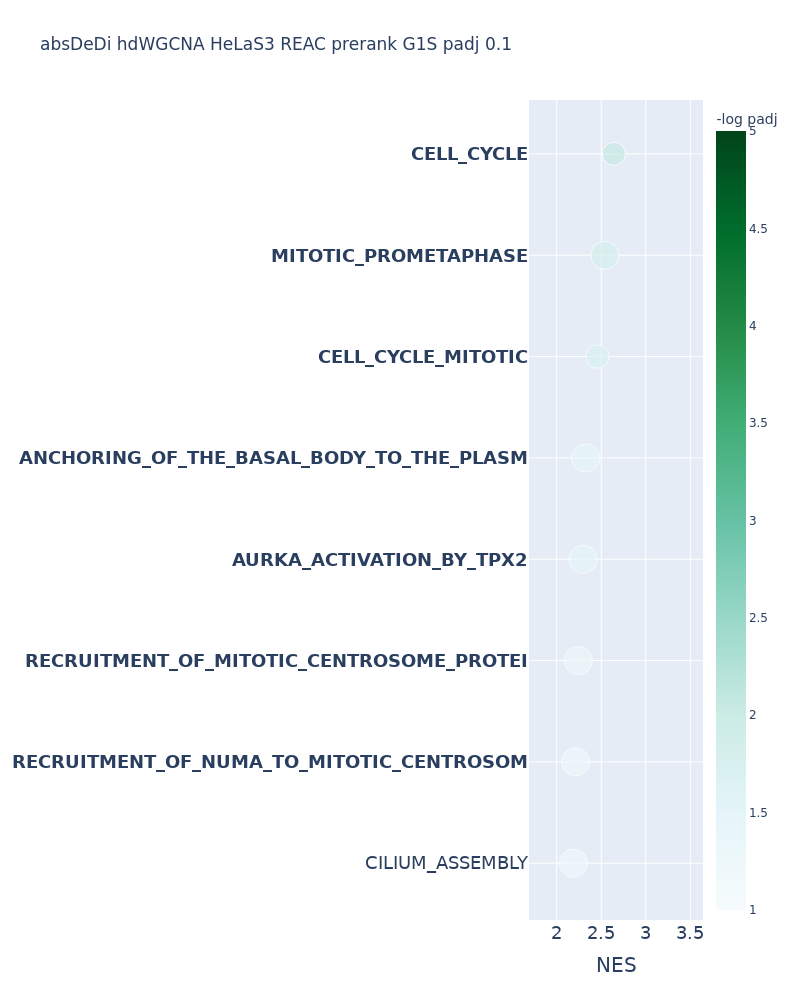

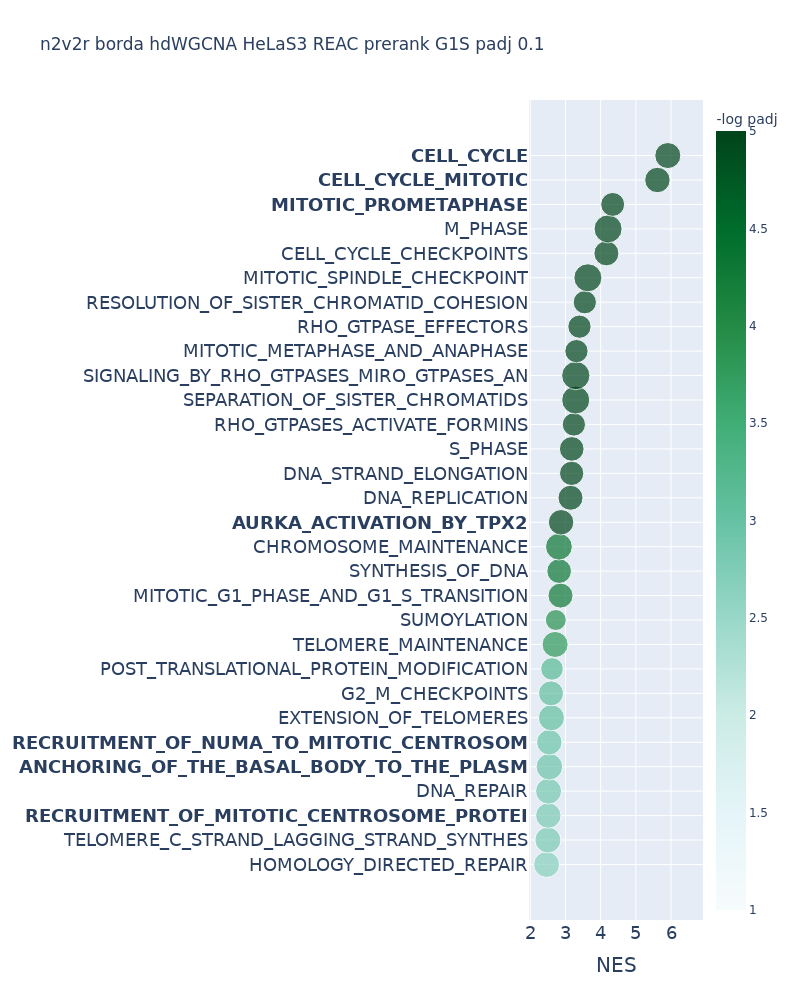

In [8]:
#plot the GSEA results

from node2vec2rank.post_utils import plot_gseapy_prerank 

padj_cutoff = 0.1

save_directory = '../results/results_gsea/' + gsea_exp_parent_folder_name

#Setting this to True, will allow the notebook figures to be interactive, e.g., hover over points and get more info
#Setting this to False will show the figure as png and non-interactive
#If True, the figures won't be shown when published on github, which is why we set it False here
interactive = False

title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) 
to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=40, trim_first_num_characters=9, padj_cutoff=padj_cutoff, plot=False)['pathway'].values
to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, output_dir=save_directory,plot=False)['pathway'].values

plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=40, trim_first_num_characters=9, padj_cutoff=padj_cutoff, title="absDeDi " +title, output_dir=save_directory,to_bold=to_bold_from_n2v2r_borda,interactive=interactive)
plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff,  title="n2v2r borda " +title, output_dir=save_directory,to_bold=to_bold_from_dedi,interactive=interactive);

No results found for absDeDi hdWGCNA HeLaS3 REAC prerank G1S padj 0.1


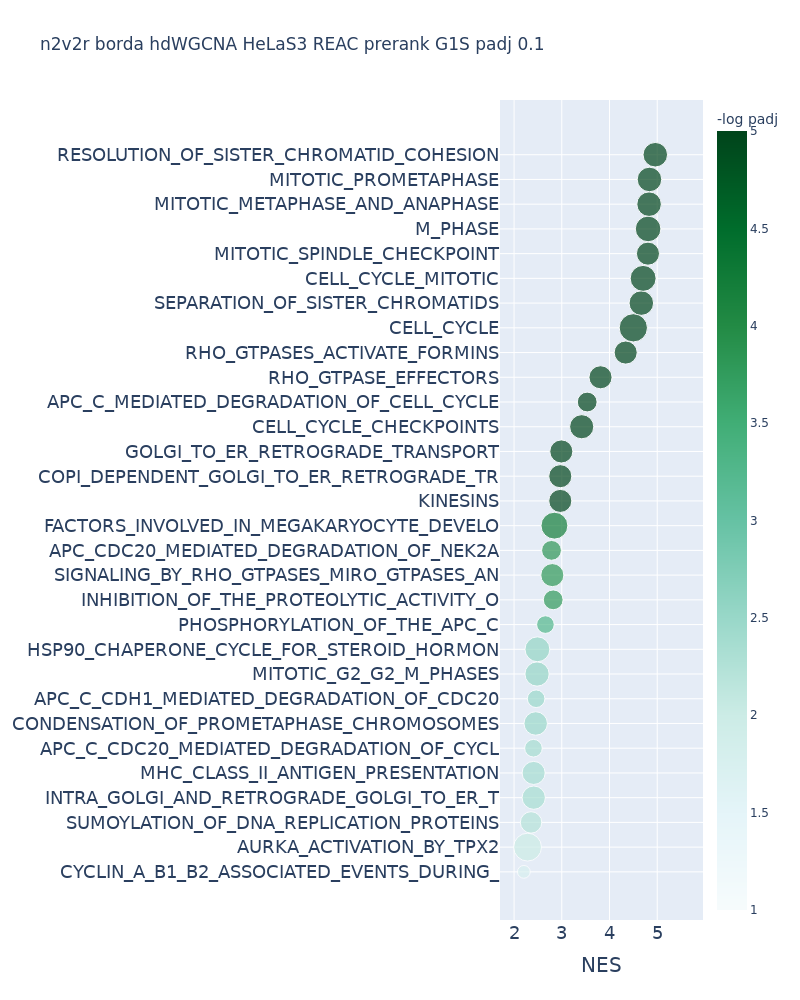

In [10]:
##now repeat for G2M

#given that this is a sequential analysis with 4 graphs, for G1S we are interested in the first comparison, and the third for G2M
target = 'G2M'

comparison = '3'
n2v2r_borda_ranking_pd = borda_ranking[comparison].copy()
absDeDi_ranking_pd = DeDi_rankings[comparison][['absDeDi']].copy()


n2v2r_borda_pre_REAC_pd = prerank_gseapy(n2v2r_borda_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)
absDeDi_pre_REAC_pd = prerank_gseapy(absDeDi_ranking_pd, reac_pathway_fn, prerank_weight=prerank_weight,
                                prerank_min_path_size=prerank_min_path_size, prerank_max_path_size=prerank_max_path_size, prerank_num_perms=prerank_num_perms, num_threads=n_cores)

if save_results:
    path = '../results/results_gsea/' + gsea_exp_parent_folder_name
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    n2v2r_borda_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target+"_n2v2r_borda" +
                            "_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    absDeDi_pre_REAC_pd.to_csv(path+"/"+tissue+"_"+network_inf_method+"_"+target +
                            "_absDeDi"+"_prerank_REAC_"+save_gsea_results_notes+".tsv", header=True, index=None, sep='\t')
    
    
    
title = network_inf_method+ " " +  tissue +  " REAC prerank " + target + " padj " + str(padj_cutoff) 

##DeDI finds nothing for G2M so we dont bold
# to_bold_from_dedi=plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=40, trim_first_num_characters=9, padj_cutoff=padj_cutoff, plot=False)['pathway'].values
# to_bold_from_n2v2r_borda=plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff, output_dir=save_directory,plot=False)['pathway'].values

plot_gseapy_prerank(absDeDi_pre_REAC_pd, has_stability=False, characters_trim=40, trim_first_num_characters=9, padj_cutoff=padj_cutoff, title="absDeDi " +title, output_dir=save_directory,interactive = interactive)
plot_gseapy_prerank(n2v2r_borda_pre_REAC_pd, has_stability=False, characters_trim=40,trim_first_num_characters=9, padj_cutoff=padj_cutoff,  title="n2v2r borda " +title, output_dir=save_directory,interactive = interactive);

